In [80]:

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.dwd_data import DWD_Dataset, Feature

import polars as pl
import pandas as pd
import os

#Tueplots

from tueplots import cycler, markers,figsizes, fonts
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes

In [81]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"


In [82]:
#Plotting Params
#Figsize
plt.rcParams.update(figsizes.icml2022_full())

from studies.utils.setup_pyplot import SIDEEFFECTS_setup_tueplot

#Font
SIDEEFFECTS_setup_tueplot()
#Color
tue_plot_colors = palettes.tue_plot
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
#Path 
FIG_SAVE_BASE_PATH = "../docs/report/fig/"


In [83]:
dataset_model_1 = DWD_Dataset(
    source_path="../data/dwd",
    model=1,
)
dataset_model_2 = DWD_Dataset(
    source_path="../data/dwd",
    model=2,
)

First look at one specific station


In [106]:
STATION_ID = 5688

/tmp/ipykernel_134112/1644131085.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df_forecast = forecast2[(forecast2["call_time"] == call_time) & (forecast1["station_id"] == STATION_ID)].sort_values(by="time")
/tmp/ipykernel_134112/1644131085.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df_forecast = forecast2[(forecast2["call_time"] == call_time) & (forecast1["station_id"] == STATION_ID)].sort_values(by="time")
/tmp/ipykernel_134112/1644131085.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df_forecast = forecast2[(forecast2["call_time"] == call_time) & (forecast1["station_id"] == STATION_ID)].sort_values(by="time")
/tmp/ipykernel_134112/1644131085.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df_forecast = forecast2[(forecast2["call_time"] == call_time) & (forecast1["station_id"] == STATION_ID)].sort_values(by="time")


2023-12-10 23:00:00 2023-12-20 20:00:00


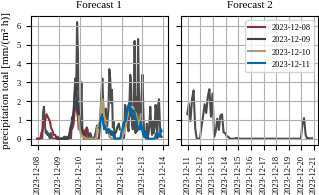

In [107]:

forecast1 = dataset_model_1.get_merge(station_id=STATION_ID).copy()
forecast2 = dataset_model_2.get_merge(station_id=STATION_ID).copy()


forecast1["call_time"] = forecast1["call_time"].dt.normalize()
forecast2["call_time"] = forecast2["call_time"].dt.normalize()

# num call times
num_call_times = 4

fig, axs = plt.subplots(ncols=2, sharey=True)
call_times = sorted(forecast1["call_time"].unique())
for call_time in call_times[:num_call_times]:
    sub_df_forecast = forecast1[(forecast1["call_time"] == call_time) & (forecast1["station_id"] == STATION_ID)].sort_values(by="time")
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    # axs[0].plot(t, sub_df_forecast["precipitation_real"], color="k", alpha=0.2)
    axs[0].plot(
        t,
        values,
        label=call_time.date(),
    )

    sub_df_forecast = forecast2[(forecast2["call_time"] == call_time) & (forecast1["station_id"] == STATION_ID)].sort_values(by="time")
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"] / 3
    # axs[1].plot(t, sub_df_forecast["precipitation_real"] / 3, color="k", alpha=0.2)
    axs[1].plot(t, values, label=call_time.date())

# add historical context
# model 1
sub_df = forecast1[
    forecast1["call_time"].isin(call_times[:num_call_times])
    & (forecast1["station_id"] == STATION_ID)
]
min_time = min(sub_df["time"])
max_time = max(sub_df["time"])
real = forecast1[
    (forecast1["time"] <= max_time)
    & (forecast1["time"].values >= min_time)
    & (forecast1["station_id"] == STATION_ID)
].sort_values(by="time")
axs[0].plot(real["time"], real["precipitation_real"], zorder=0, c="k", alpha=0.7)
# model 2
sub_df = forecast2[
    forecast2["call_time"].isin(call_times[:num_call_times])
    & (forecast2["station_id"] == STATION_ID)
]
min_time = min(sub_df["time"])
max_time = max(sub_df["time"])
print(min_time, max_time)
real = forecast2[
    (forecast2["time"] <= max_time)
    & (forecast2["time"].values >= min_time)
    & (forecast2["station_id"] == STATION_ID)
].sort_values(by="time")
axs[1].plot(real["time"], real["precipitation_real"] / 3, zorder=0, c="k", alpha=0.7)


axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Forecast 1")
axs[0].set_ylabel("precipitation total [mm/(m² h)]")
axs[0].grid()
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Forecast 2")
axs[1].legend()
axs[1].grid()


fig.savefig(FIG_SAVE_BASE_PATH + "precipitation_forecast.pdf")

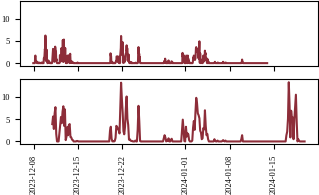

In [108]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
real_data = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[0].plot(real_data["time"], real_data["precipitation_real"])
real_data = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[1].plot(real_data["time"], real_data["precipitation_real"])

axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)

Text(0.5, 0.98, 'Difference: Precipitation Forecast and Historical Precipitation for station: 5688')

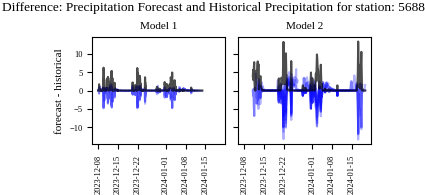

In [109]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2, sharex=True, sharey=True
)
merge1 = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
merge2 = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")

# fig, ax1 = plt.subplots()

api_call_times = sorted(merge1["call_time"].unique())
num_api_calls = len(api_call_times)
for idx, call_time in enumerate(api_call_times):
    sub_df_forecast = merge1[merge1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax1.plot(t, error, c="b", alpha=0.3)

    sub_df_forecast = merge2[merge2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax2.plot(t, error, c="b", alpha=0.3)

# plot real amount of rain
ax1.plot(
    merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain"
)
ax2.plot(
    merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain"
)

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax2.set_title("Model 2")
fig.suptitle(
    "Difference: Precipitation Forecast and Historical Precipitation for station: "
    + str(STATION_ID)
)

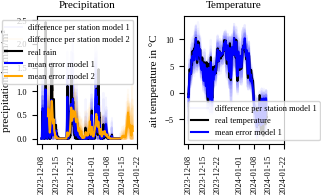

In [88]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
merge1 = dataset_model_1.get_merge()
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


individual_groups = merge1.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_forecast"],
        c="blue",
        alpha=0.04,
        label="difference per station model 1" if not idx else "",
    )

    ax2.plot(
        sub_df.index,
        sub_df["air_temperature_forecast"],
        c="blue",
        alpha=0.04,
        label="difference per station model 1" if not idx else "",
    )

individual_groups = merge2.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_forecast"] / 3,
        c="orange",
        alpha=0.04,
        label="difference per station model 2" if not idx else "",
    )


time_group = merge1.groupby(["time"]).mean()
ax1.plot(time_group.index, time_group["precipitation_real"], c="k", label="real rain")
ax1.plot(
    time_group.index,
    time_group["precipitation_forecast"],
    c="b",
    label="mean error model 1",
)


time_group = merge2.groupby(["time"]).mean()
ax1.plot(
    time_group.index,
    time_group["precipitation_forecast"] / 3,
    c="orange",
    label="mean error model 2",
)

time_group = merge1.groupby(["time"]).mean()
ax2.plot(
    time_group.index,
    time_group["air_temperature_real"],
    c="k",
    label="real temperature",
)
ax2.plot(
    time_group.index,
    time_group["air_temperature_forecast"],
    c="b",
    label="mean error model 1",
)


# ax1.plot(merge1.index, merge1["precipitation_real"], c="k", label="real_rain")
#
#
# ax2.plot(merge2.index, merge2["precipitation_error"], c="b", label="mean error")
# ax2.plot(merge2.index, merge2["precipitation_real"], c="k", label="real_rain")


#
# api_call_times = sorted(merge1["call_time"].unique())
# num_api_calls = len(api_call_times)
# for idx, call_time in enumerate(api_call_times):
#     sub_df_forecast = merge1[merge1["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax1.plot(t, error, c="b", alpha=0.3)
#
#
#     sub_df_forecast = merge2[merge2["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax2.plot(t, error, c="b", alpha=0.3)
#
# # plot real amount of rain
# ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
# ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
#
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("precipitation in mm/m²")
ax2.set_ylabel("ait temperature in °C")
ax1.set_title("Precipitation")
ax2.set_title("Temperature")
ax1.legend()
ax2.legend()
# fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))
#
# # compute correlation

what is the relative error $(forecast - historical) / historical$


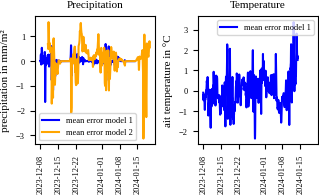

In [89]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
merge1 = dataset_model_1.get_merge()
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


individual_groups = merge1.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    # ax1.plot(sub_df.index, sub_df["precipitation_error"] / (sub_df["precipitation_real"] + 1e-16), c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

    # ax2.plot(sub_df.index, sub_df["air_temperature_error"], c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

individual_groups = merge2.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    # ax1.plot(sub_df.index, sub_df["precipitation_error"] / (sub_df["precipitation_real"] + 1e-16), c="orange", alpha=0.04, label="difference per station model 2" if not idx else "")


time_group = merge1.groupby(["time"]).mean()
# ax1.plot(time_group.index, time_group["precipitation_real"], c="k", label="real rain")
ax1.plot(
    time_group.index,
    time_group["precipitation_error"],
    c="b",
    label="mean error model 1",
)


time_group = merge2.groupby(["time"]).mean()
ax1.plot(
    time_group.index,
    time_group["precipitation_error"],
    c="orange",
    label="mean error model 2",
)

time_group = merge1.groupby(["time"]).mean()
# ax2.plot(time_group.index, time_group["air_temperature_real"], c="k", label="real temperature")
ax2.plot(
    time_group.index,
    time_group["air_temperature_error"],
    c="b",
    label="mean error model 1",
)


# ax1.plot(merge1.index, merge1["precipitation_real"], c="k", label="real_rain")
#
#
# ax2.plot(merge2.index, merge2["precipitation_error"], c="b", label="mean error")
# ax2.plot(merge2.index, merge2["precipitation_real"], c="k", label="real_rain")


#
# api_call_times = sorted(merge1["call_time"].unique())
# num_api_calls = len(api_call_times)
# for idx, call_time in enumerate(api_call_times):
#     sub_df_forecast = merge1[merge1["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax1.plot(t, error, c="b", alpha=0.3)
#
#
#     sub_df_forecast = merge2[merge2["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax2.plot(t, error, c="b", alpha=0.3)
#
# # plot real amount of rain
# ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
# ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
#
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("precipitation in mm/m²")
ax2.set_ylabel("ait temperature in °C")
ax1.set_title("Precipitation")
ax2.set_title("Temperature")
ax1.legend()
ax2.legend()
# fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))
#
# # compute correlation

What is the general trend of the error in model 1 and model 2


In [90]:
merge1 = dataset_model_1.get_merge()

call_times = sorted(merge1["call_time"].unique())
station_ids = sorted(merge1["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge1[
            (merge1["call_time"] == call_time) & (merge1["station_id"] == station_id)
        ]

        if len(sub_df_forecast) < 72:
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"].values[:72])

    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_1 = np.stack(result)

In [91]:
merge2 = dataset_model_2.get_merge()

call_times = sorted(merge2["call_time"].unique())
station_ids = sorted(merge2["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge2[
            (merge2["call_time"] == call_time) & (merge2["station_id"] == station_id)
        ]

        if (
            len(sub_df_forecast) < 56
        ):  # 56 is how many samples are expected in a forecast of model 2
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"][:56])

    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_2 = np.stack(result)
error_mat_model_2 /= 3

coef model 1
[-0.00706224  0.00033481]
coef model 2
[ 0.05722677 -0.00130679]


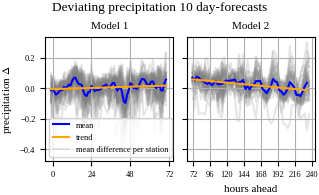

In [92]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
# fig, ax1 = plt.subplots()
fig.suptitle("Deviating precipitation 10 day-forecasts")

# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


# plot means
mean_time_delta = merge1.groupby("time_delta").mean().iloc[:-1]
t = mean_time_delta.index.values / (3600 * 1e9)  # to hours
ax1.plot(t, mean_time_delta["precipitation_error"], c="b", label="mean")
# trend regression
x = np.arange(len(mean_time_delta))[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = (
    np.linalg.inv(x_aug.T @ x_aug)
    @ x_aug.T
    @ mean_time_delta["precipitation_error"].values
)
regression = x_aug @ regression_coef
ax1.plot(t, regression, color="orange", label="trend")
print("coef model 1")
print(regression_coef)

mean_time_delta = merge2.groupby("time_delta").mean().iloc[:-1]
t = mean_time_delta.index.values / (3600 * 1e9)  # to hours
ax2.plot(t, mean_time_delta["precipitation_error"] / 3, c="b", label="stations mean")
# trend regression
x = np.arange(len(mean_time_delta))[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = (
    np.linalg.inv(x_aug.T @ x_aug)
    @ x_aug.T
    @ mean_time_delta["precipitation_error"].values
    / 3
)
regression = x_aug @ regression_coef
ax2.plot(t, regression, color="orange", label="trend")
print("coef model 2")
print(regression_coef)


# plot grey lines per station
mean_time_delta = merge1.groupby(["time_delta", "station_id"]).mean().iloc[:-1]
for idx, station_id in enumerate(merge1["station_id"].unique()):
    sub_df = mean_time_delta.xs(station_id, level="station_id")
    t = sub_df.index.values / (3600 * 1e9)  # to hours
    ax1.plot(
        t,
        sub_df["precipitation_error"],
        label="mean difference per station" if idx == 0 else "",
        color="grey",
        alpha=0.2,
        zorder=0,
    )

# plot grey lines per station
mean_time_delta = merge2.groupby(["time_delta", "station_id"]).mean().iloc[:-1]
for idx, station_id in enumerate(merge2["station_id"].unique()):
    sub_df = mean_time_delta.xs(station_id, level="station_id")
    t = sub_df.index.values / (3600 * 1e9)  # to hours
    ax2.plot(
        t,
        sub_df["precipitation_error"] / 3,
        label="mean difference of station" if idx == 0 else "",
        color="grey",
        alpha=0.2,
        zorder=0,
    )


ax1.set_ylabel("precipitation $\Delta$")
ax1.set_title("Model 1")
ax2.set_xlabel("hours ahead")
ax1.set_xticks(np.linspace(0, 72, 4, dtype=int), np.linspace(0, 72, 4, dtype=int))
ax1.grid()
ax1.legend()

ax2.set_title("Model 2")
#ax2.set_xlabel("time step into the future in hours")
ax2.set_xticks(
    np.linspace(0, 56, 8, dtype=int) * 3 + 72, np.linspace(0, 56, 8, dtype=int) * 3 + 72
)
ax2.grid()

plt.savefig(os.path.join(FIG_SAVE_BASE_PATH,'fig_mean_trend.pdf'))
# TODO: one plot?????
# TODO: what is more important: graphic with grey line or tube of standard diviation?
# TODO: This or the absolute error

FFT


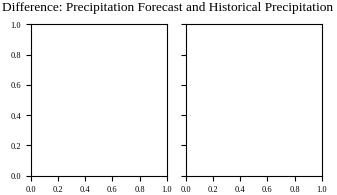

In [93]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
# fig, ax1 = plt.subplots()
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()


# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)

get confidence intervalls of the mean curve (blue) with bootstrap


In [94]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000

# MODEL 1

flatten_errors_1 = np.concatenate(error_mat_model_1, axis=0)
N_1 = len(
    flatten_errors_1
)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_1 = np.empty((flatten_errors_1.shape[1], N_BOOT))

for idx, time_step_error in enumerate(
    tqdm(flatten_errors_1.T, desc="Bootstrap Model 1")
):
    simulated_errors = np.random.choice(
        time_step_error, size=(N_BOOT, N_1), replace=True
    )
    mean_1 = simulated_errors.mean(axis=1)
    # print(boot_strap_means_1.shape, mean.shape)
    boot_strap_means_1[idx] = simulated_errors.mean(axis=1)
# MODEL 2

flatten_errors_2 = np.concatenate(error_mat_model_2, axis=0)
N_2 = len(
    flatten_errors_2
)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_2 = np.empty((flatten_errors_2.shape[1], N_BOOT))

for idx, time_step_error in enumerate(
    tqdm(flatten_errors_2.T, desc="Bootstrap Model 2")
):
    simulated_errors = np.random.choice(
        time_step_error, size=(N_BOOT, N_1), replace=True
    )
    mean_1 = simulated_errors.mean(axis=1)
    boot_strap_means_2[idx] = simulated_errors.mean(axis=1)

Bootstrap Model 2: 100%|██████████| 56/56 [00:12<00:00,  4.36it/s]


In [95]:
boot_strap_means_2.shape

(56, 10000)

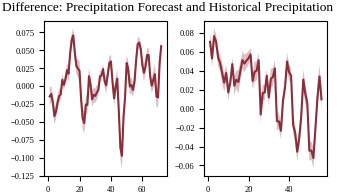

In [96]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

x_axis = np.arange(1, 73)
mean_1 = boot_strap_means_1.mean(axis=1)
std_1 = boot_strap_means_1.std(axis=1)

ax1.plot(x_axis, mean_1)
ax1.fill_between(x_axis, mean_1 - std_1, mean_1 + std_1, alpha=0.3)


x_axis = np.arange(1, 57)
mean_2 = boot_strap_means_2.mean(axis=1)
std_2 = boot_strap_means_2.std(axis=1)

ax2.plot(x_axis, mean_2)
ax2.fill_between(x_axis, mean_2 - std_2, mean_2 + std_2, alpha=0.3)

# TODO: ellipse plots????

look at the covariance between the estimated mean and the estimated standard variance.


Correlation matrix between mean and standard variance for model 1
[[0.07545345 0.00056125]
 [0.00056125 0.00912829]]
Correlation matrix between mean and standard variance for model 2
[[0.08102602 0.01051882]
 [0.01051882 0.00485893]]


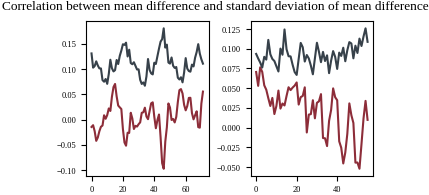

In [97]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
fig.suptitle(
    "Correlation between mean difference and standard deviation of mean difference"
)


ax1.plot(mean_1)
ax1.plot(std_1 * 10)

estimator_properties = np.stack([mean_1, std_1]).T
print("Correlation matrix between mean and standard variance for model 1")
print(estimator_properties.T @ estimator_properties)

ax2.plot(mean_2)
ax2.plot(std_2 * 10)

estimator_properties = np.stack([mean_2, std_2]).T
print("Correlation matrix between mean and standard variance for model 2")
print(estimator_properties.T @ estimator_properties)

Do a FFT on errors:


Do fft: 100%|██████████| 36/36 [00:00<00:00, 20418.52it/s]


Do fft: 100%|██████████| 1/1 [00:00<00:00, 2924.90it/s]


Text(0.5, 0, 'Frequency in 1 / day ')

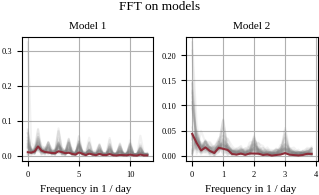

In [98]:
from typing import Tuple
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt


def do_fft(time_series: np.ndarray, period: float = 1) -> Tuple[np.ndarray, np.ndarray]:
    """perform fft on given time series

    Args:
        time_series (np.ndarray): shape (num_series, length of series)
        period (float, optional): _description_. Defaults to 1.

    Returns:
        Tuple[np.ndarray, np.ndarray]: _description_
    """
    # Number of sample points
    N = time_series.shape[-1]
    # sample spacing

    result = np.empty((time_series.shape[0], time_series.shape[1] // 2))
    for idx, station_error in enumerate(tqdm(time_series, desc="Do fft")):
        yf = fft(station_error)
        yf = 2.0 / N * np.abs(yf[0 : N // 2])
        result[idx] = yf

    xf = fftfreq(N, period)[: N // 2]
    return xf, result


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
fig.suptitle("FFT on models")

# station_errors_model_1 = np.concatenate(error_mat_model_1, axis=0)
station_errors_model_1 = error_mat_model_1.mean(axis=0)
T = 3600
xf, yf = do_fft(station_errors_model_1, T)
xf *= T * 24
ax1.plot(xf, yf.T, color="grey", alpha=0.1)
ax1.plot(xf, do_fft(station_errors_model_1.mean(axis=0)[None], T)[1].T)


station_errors_model_2 = error_mat_model_2.mean(axis=0)
T = 3600 * 3
xf, yf = do_fft(station_errors_model_2, T)
xf *= T * 8
ax2.plot(xf, yf.T, color="grey", alpha=0.1)
ax2.plot(xf, do_fft(station_errors_model_2.mean(axis=0)[None], T)[1].T)

# convert xf
# xf *= 3600 * 24
# ax2.plot(xf, yf.T, c="grey", alpha=0.01)
# ax2.plot(xf, yf.mean(axis=0))
# ax2.plot(xf, yf.mean(axis=0))

ax1.grid()
ax1.set_title("Model 1")
ax1.set_xlabel("Frequency in 1 / day ")
ax2.grid()
ax2.set_title("Model 2")
ax2.set_xlabel("Frequency in 1 / day ")

Is one call time prone to errors


correlation between expected absolute difference depending on call time
Model 1
                        precipitation_real  precipitation_forecast
precipitation_real                1.000000                0.916531
precipitation_forecast            0.916531                1.000000

 Model 2
                        precipitation_real  precipitation_forecast
precipitation_real                 1.00000                 0.69873
precipitation_forecast             0.69873                 1.00000


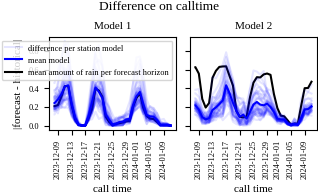

In [99]:
merge1 = dataset_model_1.get_merge()
merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
merge2["precipitation_error"] = merge2["precipitation_error"].abs()


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle("Difference on calltime")


individual_groups = merge1.groupby(["station_id", "call_time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"],
        c="blue",
        alpha=0.1,
        label="difference per station model" if not idx else "",
    )

individual_groups = merge2.groupby(["station_id", "call_time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax2.plot(
        sub_df.index,
        sub_df["precipitation_error"] / 3,
        c="b",
        alpha=0.1,
        label="difference per station model" if not idx else "",
    )

# add mean values

call_time_groups_1 = merge1.groupby(["call_time"]).mean()
t = call_time_groups_1.index.values
# t = t - min(t)
# t = t / (3600 * 24 * 1e9)
ax1.plot(t, call_time_groups_1["precipitation_error"], label="mean model", c="b")
ax1.plot(t, call_time_groups_1["precipitation_real"], c="k", zorder=0, label="mean amount of rain per forecast horizon")

call_time_groups_2 = merge2.groupby(["call_time"]).mean()
t = call_time_groups_2.index.values
# t = t - min(t)
# t = t / (3600 * 24 * 1e9)
ax2.plot(t, call_time_groups_2["precipitation_error"] / 3, label="mean model", c="b")
ax2.plot(t, call_time_groups_2["precipitation_real"], c="k", zorder=0, label="mean amount of rain per forecast horizon")

# add rain

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel("call time")
ax1.set_ylabel("|forecast - historical|")
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel("call time")
ax1.set_title("Model 1")
ax2.set_title("Model 2")
ax1.legend()



# compute correlation
print("correlation between expected absolute difference depending on call time")
print("Model 1")
corr_df = call_time_groups_1[["precipitation_real", "precipitation_forecast"]].corr()
print(corr_df)
print("\n Model 2")
corr_df = call_time_groups_2[["precipitation_real", "precipitation_forecast"]].corr()
print(corr_df)



which time between 0 and 24 is prone to errors


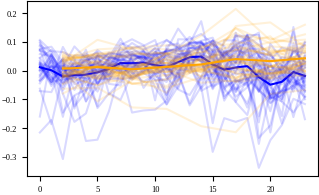

In [100]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax1 = plt.subplots()

# insert hour column
merge1.insert(
    len(merge1.columns), "hour", merge1["time"].dt.hour, allow_duplicates=True
)

individual_groups = merge1.groupby(["station_id", "hour"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"],
        c="blue",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

time_group = merge1.groupby(["hour"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"].values, c="b")

# insert hour column
merge2.insert(
    len(merge2.columns), "hour", merge2["time"].dt.hour, allow_duplicates=True
)
individual_groups = merge2.groupby(["station_id", "hour"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"] / 3,
        c="orange",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

time_group = merge2.groupby(["hour"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"].values / 3, c="orange")

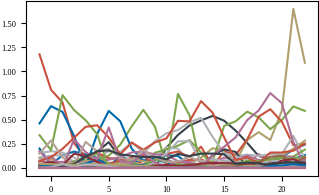

In [101]:
from scipy.stats import linregress

merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# fig, ax1 = plt.subplots(subplot_kw={'projection': 'polar'})
fig, ax1 = plt.subplots()


# insert column
merge1.insert(
    len(merge1.columns), "hour", merge1["time"].dt.hour, allow_duplicates=True
)

first_call_time = merge1["call_time"].unique()[0]
# station_data = merge1[(merge1["station_id"] == STATION_ID) & (merge1["call_time"] == first_call_time)].sort_values(by="time")
# station_data = merge1[(merge1["station_id"] == STATION_ID)].groupby("time").mean()
station_data = merge1.groupby("time").mean()
# ax1.plot(station_data["time"], station_data["precipitation_forecast"])

# values = station_data["precipitation_error"].values.reshape(3, len(station_data) // 3).T
# t = station_data["hour"].values.reshape(3, len(station_data) // 3)
t = station_data["hour"].values
t[t == 23] = -1
index = np.where(t == -1)[0]
t = np.split(t, index)
values = station_data["precipitation_error"].values
values = np.split(values, index)

for t, v in zip(t, values):
    ax1.plot(t, np.abs(v))

# ax1.set_yscale("log")
# t
# time_group_slope = merge2.groupby(["station_id", "time"]).apply(lin_reg)
# for idx, station_id in enumerate(time_group_slope.index.get_level_values("station_id").unique()):
#     sub_df = time_group_slope.xs(station_id, level="station_id")
#     slope, intercept, r_2 = zip(*sub_df.values)
#     ax1.plot(sub_df.index, slope, c="blue", alpha=0.15, label="slope" if not idx else "")
#     # ax1.plot(sub_df.index, intercept, c="green", alpha=0.15, label="intercept" if not idx else "")
#     ax1.plot(sub_df.index, r_2, c="orange", alpha=0.15, label="difference per station model 2" if not idx else "")

change of forecast


/home/lilli288/miniconda3/envs/project/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/lilli288/miniconda3/envs/project/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/lilli288/miniconda3/envs/project/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


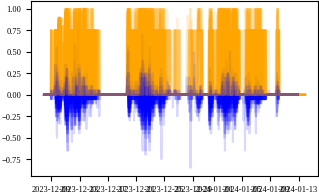

In [102]:
from scipy.stats import linregress

merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax1 = plt.subplots()


def lin_reg(series):
    if not len(series):
        return 0, 1

    series = series.sort_values(by="call_time")

    x = np.arange(len(series))
    y = series[
        "precipitation_error"
    ].abs()  # expect: negative slope -> the error should go down if we move closer to the prediction time
    # y = series["precipitation_forecast"]  # look if the forecast is more over or under estimating  with the assumption that the error goes down if we move further to the target
    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, r_value**2


time_group_slope = merge1.groupby(["station_id", "time"]).apply(lin_reg)
for idx, station_id in enumerate(
    time_group_slope.index.get_level_values("station_id").unique()
):
    sub_df = time_group_slope.xs(station_id, level="station_id")
    slope, intercept, r_2 = zip(*sub_df.values)
    ax1.plot(
        sub_df.index, slope, c="blue", alpha=0.15, label="slope" if not idx else ""
    )
    # ax1.plot(sub_df.index, intercept, c="green", alpha=0.15, label="intercept" if not idx else "")
    ax1.plot(
        sub_df.index,
        r_2,
        c="orange",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

(257, Timestamp('2023-12-13 23:00:00'))


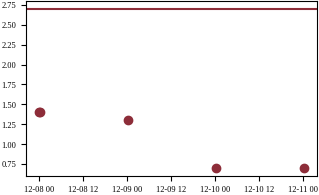

In [103]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax2 = plt.subplots()


for index, values in merge2.groupby(["station_id", "time"]):
    if len(values) < 5:
        continue
    print(index)
    ax2.scatter(values["call_time"], values["precipitation_forecast"])
    ax2.axhline(values["precipitation_real"].values[0])
    break

In [104]:
import pandas as pd


merge1 = dataset_model_1.get_merge(columns=["time", "call_time", "station_id", "precipitation_real", "precipitation_forecast"])
merge2 = dataset_model_2.get_merge(columns=["time", "call_time", "station_id", "precipitation_real", "precipitation_forecast"])

# normalize calltime 
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()

# scale merge2
merge2["precipitation_forecast"] = merge2["precipitation_forecast"] / 3
merge2["precipitation_real"] = merge2["precipitation_real"] / 3

# shrink dataset with only precipitation  features in columns
merge3 = pd.merge(merge1, merge2, how="inner", on=["time", "station_id"])
merge3 = merge3.dropna()  # there is one station without real data

# sort by call time for short-term forecast
merge3 = merge3.sort_values(by="time")

def lin_reg(series: pd.DataFrame):
    forecast1 = series[["call_time_x", "precipitation_forecast_x", "precipitation_real_x"]]
    forecast2 = series[["call_time_y", "precipitation_forecast_y", "precipitation_real_y"]]

    # rename column
    forecast1 = forecast1.rename(columns={"call_time_x": "call_time", "precipitation_forecast_x": "precipitation_forecast", "precipitation_real_x": "precipitation_real"})
    forecast2 = forecast2.rename(columns=    {"call_time_y": "call_time", "precipitation_forecast_y": "precipitation_forecast", "precipitation_real_y": "precipitation_real"})
    
    forecast2 = forecast2.drop_duplicates()
    forecast1 = forecast1.drop_duplicates()

    concat = pd.concat([forecast1, forecast2]).sort_values(by="call_time")
    
    t = np.arange(len(concat))
    error = np.abs((concat["precipitation_forecast"] - concat["precipitation_real"]).values)
    slope, intercept, r_value, p_value, std_err = linregress(t, error)
    
    lin_reg_columns = ["slope", "intercept", "r_value", "p_value", "std_err", "num_samples"]
    lin_reg_series = pd.Series(index=lin_reg_columns, data=[slope, intercept, r_value, p_value, std_err, len(concat)])
    return lin_reg_series



lin_reg_df = merge3.groupby(["time", "station_id"]).apply(lin_reg)

                                slope  intercept  r_value  p_value  std_err  \
time                station_id                                                
2023-12-16 23:00:00 257           0.0        0.0      0.0      1.0      0.0   
                    259           0.0        0.0      0.0      1.0      0.0   
                    755           0.0        0.0      0.0      1.0      0.0   
                    757           0.0        0.0      0.0      1.0      0.0   
                    1197          0.0        0.0      0.0      1.0      0.0   
...                               ...        ...      ...      ...      ...   
2024-01-11 20:00:00 6262          0.0        0.0      0.0      1.0      0.0   
                    6263          0.0        0.0      0.0      1.0      0.0   
                    6275          0.0        0.0      0.0      1.0      0.0   
                    7331          0.0        0.0      0.0      1.0      0.0   
                    13965         0.0        0.0    

TypeError: Cannot index by location index with a non-integer key

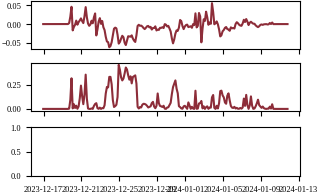

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)

# cut every point which has not the max length
max_length  = max(lin_reg_df["num_samples"])
lin_reg_df = lin_reg_df[lin_reg_df["num_samples"] >= (max_length - 1)]
print(lin_reg_df)
mean = lin_reg_df.groupby("time").mean()
t = mean.index
ax1.plot(t, mean["slope"])
ax2.plot(t, mean["r_value"]**2)
# ax3.plot(mean.index, mean["num_samples"])
time_mean = merge1.groupby("time").mean()
print(time_mean.iloc[0])
precipitation_real = time_mean.loc[time_mean.iloc["time"], "precipitation_real"]
ax3.plot(time_mean.index, precipitation_real)
ax3.plot(time_mean.index[1:], np.abs(np.diff(precipitation_real.values)))

In [ ]:
import pandas as pd

# Create a sample DataFrame
data = {
    "Category": ["A", "A", "B", "B", "A", "B"],
    "Value": [10, 15, 20, 18, 25, 22],
    "Value2": [11, 15, 21, 19, 25, 23],
}
df = pd.DataFrame(data)


# Define a custom aggregate function
def custom_aggregate(series):
    print(series)
    print("_____")
    return series.max() - series.min()


# Apply the custom aggregate function using groupby and aggregate
result = df.groupby("Category").aggregate(custom_aggregate)

print(result)

0    10
1    15
4    25
Name: Value, dtype: int64
_____
2    20
3    18
5    22
Name: Value, dtype: int64
_____
0    11
1    15
4    25
Name: Value2, dtype: int64
_____
2    21
3    19
5    23
Name: Value2, dtype: int64
_____
          Value  Value2
Category               
A            15      14
B             4       4


In [ ]:
def get_delta_seconds(series):
    return series.total_seconds()

        precipitation_forecast  air_temperature_forecast  precipitation_real  \
0                          0.0                      -9.3                 0.0   
1                          0.0                      -7.5                 0.0   
2                          0.0                      -7.4                 0.0   
3                          0.0                      -7.1                 0.0   
4                          0.0                      -7.2                 0.0   
...                        ...                       ...                 ...   
103749                     0.0                       8.0                 0.0   
103750                     0.0                       7.8                 0.0   
103751                     0.0                       7.7                 0.0   
103752                     0.0                       7.8                 0.0   
103753                     0.0                       7.6                 0.0   

        air_temperature_real  precipita

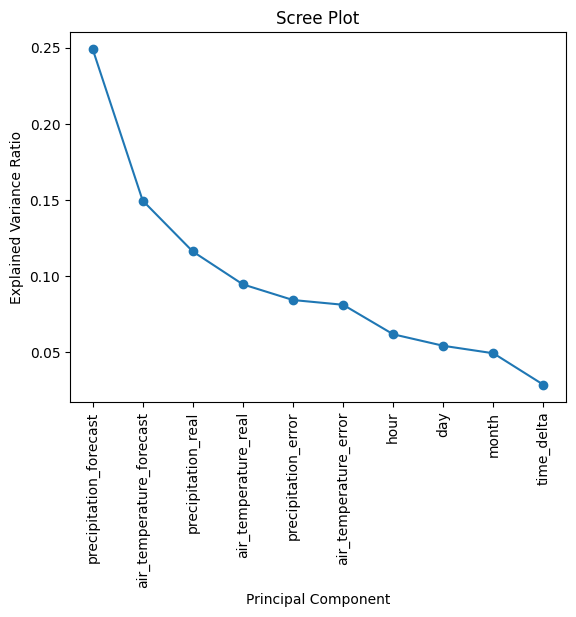

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()
merge2 = merge2.drop(columns=["air_temperature_forecast", "air_temperature_error"])


station_meta = dataset_model_1._stations
used_station_ids = merge1["station_id"].unique()
station_meta = station_meta[
    station_meta["Stations_ID"].isin(used_station_ids)
    & (station_meta["Kennung"] == "MN")
]
coords = station_meta[["Stations_ID", "Breite", "Länge", "Stations-höhe"]]
coords = coords.rename(
    columns={
        "Stations_ID": "station_id",
        "Breite": "lat",
        "Länge": "lon",
        "Stations-höhe": "height",
    }
)
# merge1 = merge2

# Extract relevant features from datetime
merge1["hour"] = merge1["time"].dt.hour
merge1["day"] = merge1["time"].dt.day
merge1["month"] = merge1["time"].dt.month
time_delta = (merge1["time"] - merge1["call_time"]).apply(get_delta_seconds)
merge1["time_delta"] = time_delta


merge1["call_day"] = merge1["call_time"].dt.day
merge1["call_month"] = merge1["call_time"].dt.day

merge1 = pd.merge(merge1, coords, how="left", on="station_id")

# Drop the original datetime column
merge1 = merge1.drop(columns="time")
merge1 = merge1.drop(columns="call_time")
merge1 = merge1.drop(columns="station_id")

print(merge1)
# merge1 = merge1.drop(columns=["height", "air_temperature_forecast", "air_temperature_real", "air_temperature_error"])
# merge1 = merge1.drop(columns=["precipitation_forecast", "precipitation_real"])


merge1

# drop columns with nan
# TODO: there are nans in the data. WHY
print(merge1.isna().sum(axis=0))
merge1 = merge1.dropna()

# Standardize numeric features
numeric_columns = merge1.columns
scaler = StandardScaler()
merge1[numeric_columns] = scaler.fit_transform(merge1[numeric_columns])

# Perform PCA
n_components = 10
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(merge1[numeric_columns])

# Print the explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)
print("Cummulative explained variance ratio: ", pca.explained_variance_ratio_.sum())

component_df = pd.DataFrame(pca.components_, columns=pca.feature_names_in_)
variance_df = pd.DataFrame(
    pca.explained_variance_ratio_[None], columns=pca.feature_names_in_[:n_components]
)

import matplotlib.pyplot as plt

fig, ax2 = plt.subplots()

ax2.plot(variance_df.columns, variance_df.values.T, marker="o")
# ax.plot(range(1, len(pca.explained_variance_ratio_) + 1),
#          pca.explained_variance_ratio_, marker='o')
ax2.set_title("Scree Plot")
ax2.set_xlabel("Principal Component")
ax2.set_ylabel("Explained Variance Ratio")
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)

Compute correlation between error and time to forecast?

<Axes: >

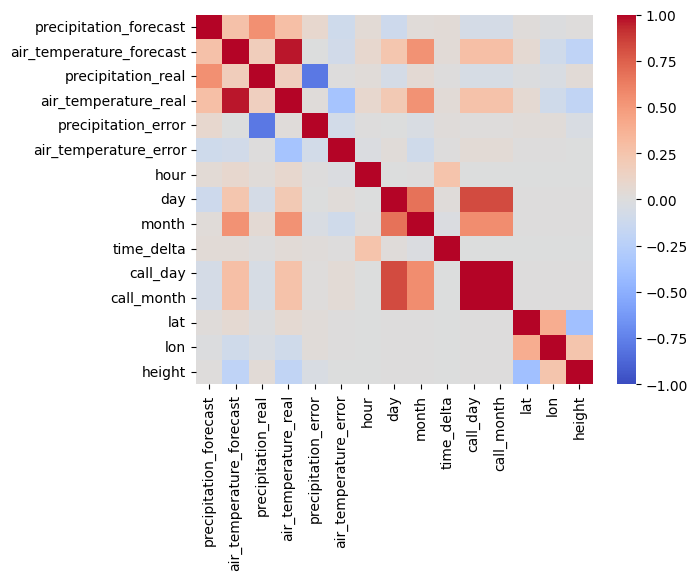

In [ ]:
import seaborn as sn

names = merge1.columns
corr = merge1.corr()
sn.heatmap(corr, cmap="coolwarm", vmax=1, vmin=-1)

Calculate rain detection

Question with with threshold can you be sure rain happens


percentage of rain samples:  0.19417082714883283
percentage of rain samples:  0.2624978817149636


Text(0.5, 0.98, 'confusion statistics of precipitation forecast')

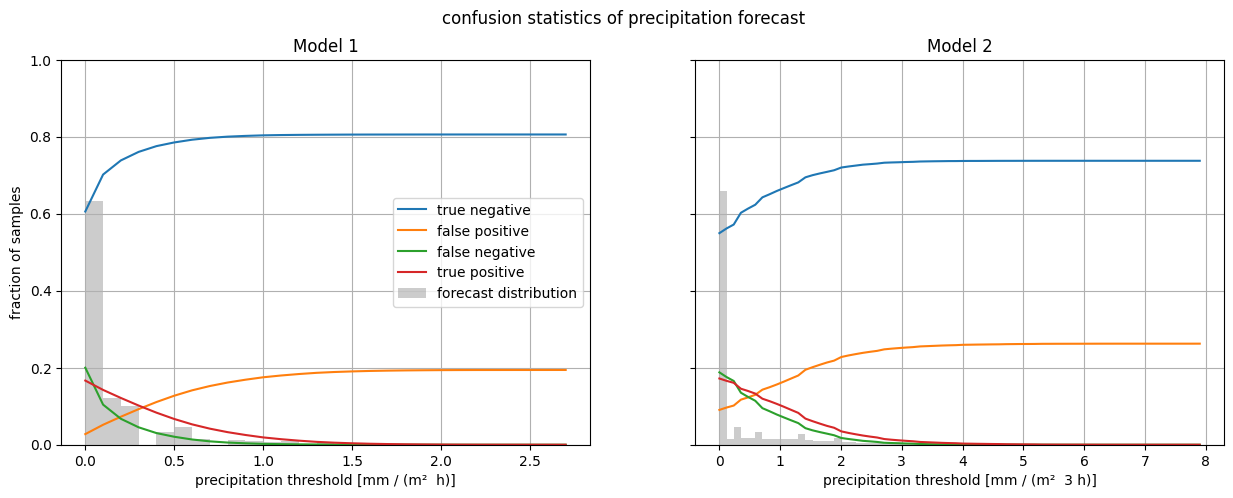

In [ ]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

from sklearn import metrics


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        return int(series > threshold)

    return inner


def create_confusion_matrices(df: pd.DataFrame, num_thresholds: int):
    actual = df["precipitation_real"].transform(bool_mask(0.0)).values
    print("percentage of rain samples: ", actual.sum() / len(actual))
    max_forecast = max(df["precipitation_forecast"])
    thresholds = np.linspace(0, max_forecast, num_thresholds)
    matrices = np.empty((num_thresholds, 2, 2))
    for idx, threshold in enumerate(thresholds):
        predicted = (
            df["precipitation_forecast"]
            .transform(bool_mask(threshold=threshold))
            .values
        )
        matrices[idx] = metrics.confusion_matrix(actual, predicted)

    return thresholds, matrices


unique_forecasts_1 = merge1["precipitation_forecast"].unique()
unique_forecasts_2 = merge2["precipitation_forecast"].unique()


thresholds1, matrices1 = create_confusion_matrices(merge1, len(unique_forecasts_1))
thresholds2, matrices2 = create_confusion_matrices(merge2, len(unique_forecasts_2))
counts1 = np.apply_over_axes(np.sum, matrices1, [-2, -1])
counts2 = np.apply_over_axes(np.sum, matrices2, [-2, -1])
matrices1 = np.divide(matrices1, counts1)
matrices2 = np.divide(matrices2, counts2)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

ax1.plot(thresholds1, matrices1[:, 0, 0], label="true negative")
ax1.plot(thresholds1, matrices1[:, 1, 0], label="false positive")
ax1.plot(thresholds1, matrices1[:, 0, 1], label="false negative")
ax1.plot(thresholds1, matrices1[:, 1, 1], label="true positive")

counts, bins = np.histogram(merge1["precipitation_forecast"], bins=thresholds1)
density = counts / sum(counts)
bin_width = bins[1] - bins[0]
ax1.bar(
    bins[:-1] + bin_width / 2,
    density,
    zorder=0,
    alpha=0.4,
    width=0.1,
    color="grey",
    label="forecast distribution",
)


ax2.plot(thresholds2, matrices2[:, 0, 0], label="true negative")
ax2.plot(thresholds2, matrices2[:, 1, 0], label="false positive")
ax2.plot(thresholds2, matrices2[:, 0, 1], label="false negative")
ax2.plot(thresholds2, matrices2[:, 1, 1], label="true positive")

counts, bins = np.histogram(merge2["precipitation_forecast"], bins=thresholds2)
density = counts / sum(counts)
bin_width = bins[1] - bins[0]
ax2.bar(
    bins[:-1] + bin_width / 2,
    density,
    zorder=0,
    alpha=0.4,
    width=0.118,
    color="grey",
    label="forecast distribution",
)

ax1.legend()
ax1.set_xlabel("precipitation threshold [mm / (m²  h)]")
ax1.set_ylabel("fraction of samples")
ax1.set_ylim((0, 1))
ax1.set_title("Model 1")
ax1.grid()
ax2.set_title("Model 2")
ax2.set_xlabel("precipitation threshold [mm / (m²  3 h)]")
ax2.grid()
fig.suptitle("confusion statistics of precipitation forecast")

/tmp/ipykernel_2764/3853865641.py:18: RuntimeWarning: invalid value encountered in divide
  recall1 = true_positive_1 / (true_positive_1 + false_negative_1)
/tmp/ipykernel_2764/3853865641.py:20: RuntimeWarning: invalid value encountered in divide
  sensitivity1 = true_positive_1 / (true_positive_1 + false_negative_1)
/tmp/ipykernel_2764/3853865641.py:25: RuntimeWarning: invalid value encountered in divide
  recall2 = true_positive_2 / (true_positive_2 + false_negative_2)
/tmp/ipykernel_2764/3853865641.py:27: RuntimeWarning: invalid value encountered in divide
  sensitivity2 = true_positive_2 / (true_positive_2 + false_negative_2)


Text(0.5, 0.98, 'confusion statistics of precipitation forecast')

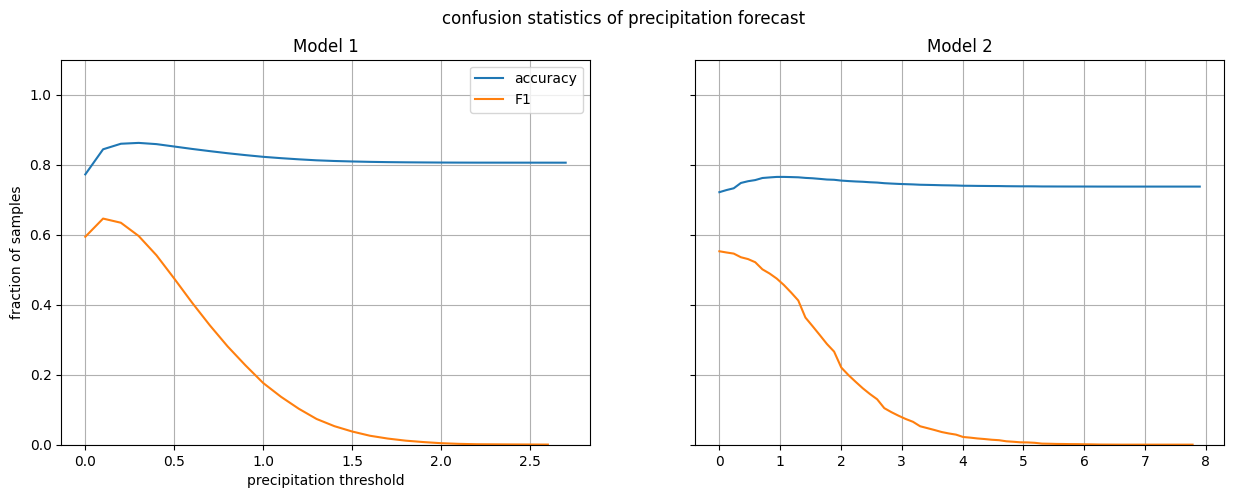

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

true_negative_1 = matrices1[:, 0, 0]
false_positive_1 = matrices1[:, 1, 0]
false_negative_1 = matrices1[:, 0, 1]
true_positive_1 = matrices1[:, 1, 1]

true_negative_2 = matrices2[:, 0, 0]
false_positive_2 = matrices2[:, 1, 0]
false_negative_2 = matrices2[:, 0, 1]
true_positive_2 = matrices2[:, 1, 1]


accuracy1 = true_positive_1 + true_negative_1
accuracy2 = true_positive_2 + true_negative_2

precision1 = true_positive_1 / (true_positive_1 + false_positive_1)
recall1 = true_positive_1 / (true_positive_1 + false_negative_1)
f1_1 = 2 * precision1 * recall1 / (precision1 + recall1)
sensitivity1 = true_positive_1 / (true_positive_1 + false_negative_1)
specificity1 = true_negative_1 / (true_negative_1 + false_positive_1)
balanced_accuracy1 = (sensitivity1 + specificity1) / 2

precision2 = true_positive_2 / (true_positive_2 + false_positive_2)
recall2 = true_positive_2 / (true_positive_2 + false_negative_2)
f1_2 = 2 * precision2 * recall2 / (precision2 + recall2)
sensitivity2 = true_positive_2 / (true_positive_2 + false_negative_2)
specificity2 = true_negative_2 / (true_negative_2 + false_positive_2)
balanced_accuracy2 = (sensitivity2 + specificity2) / 2


ax1.plot(thresholds1, accuracy1, label="accuracy")
ax2.plot(thresholds2, accuracy2, label="accuracy")
# ax1.plot(thresholds1, balanced_accuracy1, label="balanced accuracy")
# ax2.plot(thresholds2, balanced_accuracy2, label="balanced accuracy")
# ax1.plot(thresholds1, precision1, label="precision")
# ax2.plot(thresholds2, precision2, label="precision")
# ax1.plot(thresholds1, recall1, label="recall")
# ax2.plot(thresholds2, recall2, label="recall")

ax1.plot(thresholds1, f1_1, label="F1")
ax2.plot(thresholds2, f1_2, label="F1")


ax1.legend()
ax1.set_xlabel("precipitation threshold")
ax1.set_ylabel("fraction of samples")
ax1.set_ylim((0, 1.1))
ax1.set_title("Model 1")
ax2.set_title("Model 2")
ax2.grid()
ax1.grid()
fig.suptitle("confusion statistics of precipitation forecast")

samples per time step into the future: 


(0.7143874643874644, 0.9034722222222222)

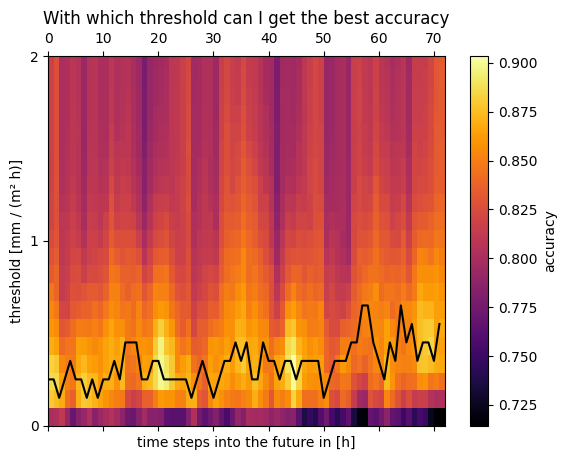

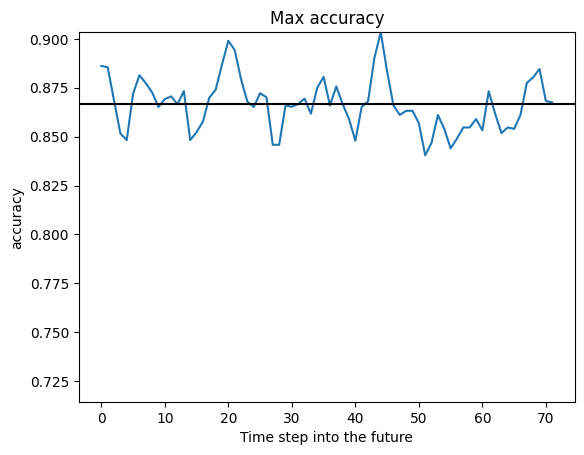

In [ ]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# add time delta
# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        result = series > threshold
        return result

    return inner


# print(merge1.groupby("time_delta")[["precipitation_real", "precipitation_forecast", "precipitation_error"]].aggregate(bool_mask(0.0)))

# set bool mask for actual values
num_thresholds = len(merge1["precipitation_forecast"].unique())
num_time_deltas = len(merge1["time_delta"].unique())
max_forecast = max(merge1["precipitation_forecast"])
thresholds = np.linspace(0, max_forecast, num_thresholds)
matrices = np.empty((num_time_deltas - 1, num_thresholds, 2, 2))
for group_index, (_, group) in enumerate(
    merge1.groupby("time_delta")[
        ["precipitation_real", "precipitation_forecast", "precipitation_error"]
    ]
):
    actual = group["precipitation_real"].apply(bool_mask(0.0)).values
    if len(group) == 2:
        continue
    for threshold_idx, threshold in enumerate(thresholds):
        transformed = group.apply(bool_mask(threshold=threshold))
        predicted = transformed["precipitation_forecast"].values
        matrices[group_index, threshold_idx] = metrics.confusion_matrix(
            actual, predicted
        )

samples_per_bucket = np.apply_over_axes(np.sum, matrices, [-2, -1])
matrices = np.divide(matrices, samples_per_bucket)

true_negative_1 = matrices[..., 0, 0]
false_positive_1 = matrices[..., 1, 0]
false_negative_1 = matrices[..., 0, 1]
true_positive_1 = matrices[..., 1, 1]


accuracy = (true_positive_1 + true_negative_1).T

print("samples per time step into the future: ")

# accuracy /= accuracy.sum(axis=0)

fig, ax1 = plt.subplots()

extent = [0, 72, max_forecast, 0]
cbar = ax1.matshow(accuracy, extent=extent, cmap="inferno")
ax1.set_aspect("auto")

threshold_bucket_with = thresholds[1]
argmax_threshold = thresholds[accuracy.argmax(axis=0)] + threshold_bucket_with / 2
ax1.plot(argmax_threshold, c="k", label="argmax_threshold")

std_over_time = accuracy.std(axis=0)
ax1.set_ylim((0, 2))
ax1.set_ylabel("threshold [mm / (m² h)]")
ax1.set_xlabel("time steps into the future in [h]")


cbar = fig.colorbar(cbar)
cbar.set_label("accuracy")

std_over_time / max_forecast

ax1.set_title("With which threshold can I get the best accuracy")

fig, ax = plt.subplots()
ax.set_title("Max accuracy")
ax.set_xlabel("Time step into the future")
ax.set_ylabel("accuracy")
ax.plot(accuracy.max(axis=0), label="max accuracy")  # TODO: adapt y scale to color bar scale
ax.axhline(accuracy.max(axis=0).mean(), c="k")
ax.set_ylim((min(cbar._boundaries), max(cbar._boundaries)))


[1.35597015 0.88432836 0.41268657 0.41268657 0.41268657 0.76641791
 1.2380597  1.12014925 1.4738806  1.00223881 0.88432836 0.88432836
 0.53059701 1.00223881 1.35597015 1.35597015 1.59179104 0.64850746
 0.76641791 0.88432836 0.53059701 0.64850746 1.12014925 1.4738806
 1.94552239 0.88432836 0.76641791 0.64850746 0.29477612 0.29477612
 3.36044776 2.77089552 3.83208955 1.00223881 1.12014925 1.00223881
 1.2380597  1.94552239 2.53507463 1.4738806  2.77089552 1.12014925
 3.7141791  0.88432836 1.00223881 2.41716418 3.24253731 3.00671642
 4.1858209  3.95       3.47835821 3.36044776 3.24253731 3.83208955
 4.42164179 3.83208955]


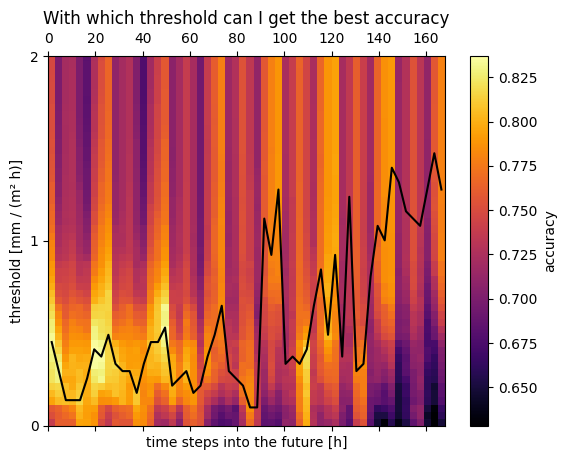

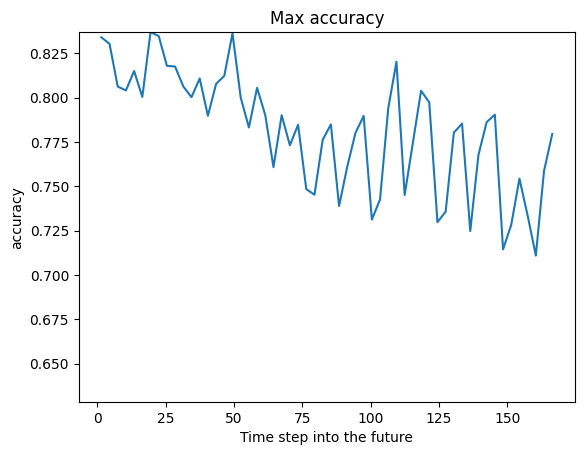

In [ ]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# add time delta
# set call time for all to 00:00
merge1["call_time"] = merge1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge1["time"] - merge1["call_time"]
merge1.insert(len(merge1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        result = series > threshold
        return result

    return inner


# print(merge1.groupby("time_delta")[["precipitation_real", "precipitation_forecast", "precipitation_error"]].aggregate(bool_mask(0.0)))

# set bool mask for actual values
num_thresholds = len(merge2["precipitation_forecast"].unique())
num_time_deltas = len(merge2["time_delta"].unique())
max_forecast = max(merge2["precipitation_forecast"])
thresholds = np.linspace(0, max_forecast, num_thresholds)
matrices = np.empty((num_time_deltas, num_thresholds, 2, 2))
time_deltas = []
for group_index, (time_delta, group) in enumerate(
    merge2.groupby("time_delta")[
        ["precipitation_real", "precipitation_forecast", "precipitation_error"]
    ]
):
    actual = group["precipitation_real"].apply(bool_mask(0.0)).values
    time_deltas.append(time_delta.seconds)
    if len(group) == 2:
        continue
    for threshold_idx, threshold in enumerate(thresholds):
        transformed = group.apply(bool_mask(threshold=threshold))
        predicted = transformed["precipitation_forecast"].values
        matrices[group_index, threshold_idx] = metrics.confusion_matrix(
            actual, predicted
        )
time_deltas = np.array(sorted(time_deltas)) // 3600

samples_per_bucket = np.apply_over_axes(np.sum, matrices, [-2, -1])
# print("samples per time step into the future: ", samples_per_bucket)

matrices = np.divide(matrices, samples_per_bucket)

true_negative_1 = matrices[..., 0, 0]
false_positive_1 = matrices[..., 1, 0]
false_negative_1 = matrices[..., 0, 1]
true_positive_1 = matrices[..., 1, 1]


accuracy = (true_positive_1 + true_negative_1).T


# accuracy /= accuracy.sum(axis=0)

fig, ax2 = plt.subplots()


extent = [0, 56 * 3, max_forecast / 3 , 0]
cbar = ax2.matshow(accuracy, extent=extent, cmap="inferno")
ax2.set_aspect("auto")

threshold_bucket_with = thresholds[1]
argmax_threshold = thresholds[accuracy.argmax(axis=0)] + threshold_bucket_with / 2
print(argmax_threshold)
ax2.plot(np.arange(56) * 3 + 1.5, argmax_threshold / 3, c="k", label="argmax_threshold")

ax2.set_ylim((0, 2))
ax2.set_ylabel("threshold [mm / (m² h)]")
ax2.set_xlabel("time steps into the future [h]")


cbar = fig.colorbar(cbar)
cbar.set_label("accuracy")


ax2.set_title("With which threshold can I get the best accuracy")


fig, ax = plt.subplots()
ax.set_title("Max accuracy")
ax.set_xlabel("Time step into the future")
ax.set_ylabel("accuracy")
ax.set_ylim((min(cbar._boundaries), max(cbar._boundaries)))
ax.plot(np.arange(56) * 3 + 1.5, accuracy.max(axis=0))


Whats the probability given a certain forecast to really getting wet

In [ ]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

actual = merge1["precipitation_real"].apply(bool_mask(0))

threshold = 0.2
predition = merge1["precipitation_forecast"]

relative error to amount of rain $ (forecast - historical) / historical$


Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


given the amount of predicted precipitation whats the expected error


In [ ]:
merge1 = dataset_model_1.get_merge

Compute on average divergence for a forecast into the future.
Observer how a forecast changes over time

relative error to amount of rain $ (forecast - historical) / historical$


jooy plot for precipitation amount across stations

----> time
|
|
V
station

z: precipitation amount of precipitation
